# Daftar isi
1. Deskripsi Proyek
2. Instruksi Tugas
3. Deskripsi Data
4. Persiapan
5. Analisis
6. Pelatihan & Pengujian

## Deskripsi Proyek

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi jumlah pesanan taksi.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom '*num_orders*'.

## Persiapan

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
#muat data
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
#cek data
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
#muat data ke format datetime
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
#cek data
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
#cek ukuran data
data.shape

(26496, 1)

In [7]:
#cek type dataset
data.dtypes

num_orders    int64
dtype: object

In [8]:
#info dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
#cek deskipsi dataset
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
#periksa missing value
data.isnull().sum()

num_orders    0
dtype: int64

In [11]:
#cek proporsi nilai dalam kolom num_orders
data['num_orders'].value_counts() / data.shape[0]*100

9     5.181914
11    5.151721
12    4.970562
10    4.966787
8     4.729016
        ...   
67    0.003774
66    0.003774
91    0.003774
82    0.003774
95    0.003774
Name: num_orders, Length: 81, dtype: float64

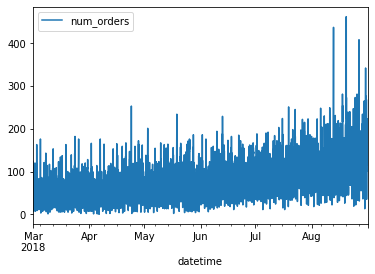

In [12]:
#resampling data satu jam
data.sort_index(inplace=True)
data = data.resample('1H').sum()

data.plot();


In [13]:
data.shape

(4416, 1)

catatan :
- dataset memiliki 26496 baris
- dataset tidak memiliki null value
- setelah dilakukan re-sampling 1 jam dataset menjadi 4416 baris


## Analisis

### Analisa _time series_

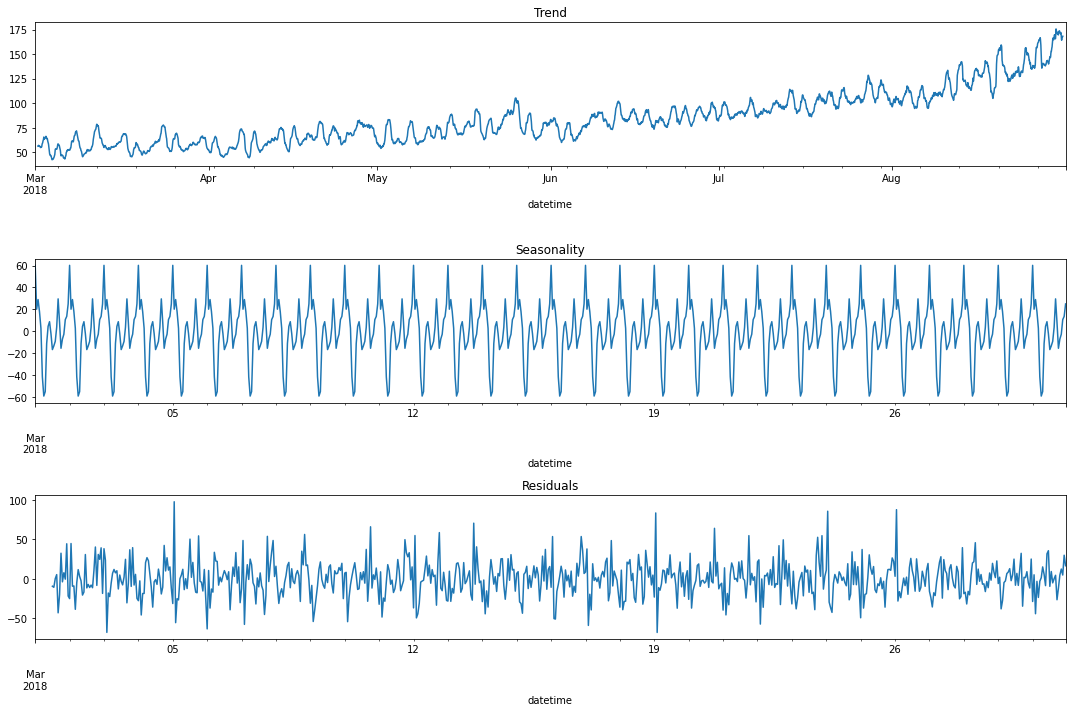

In [14]:
#time series analysis

decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(311)

#cek trending semua data
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

#cek seasonal data - untuk bulan maret
decomposed.seasonal['2018-03-01':'2018-03-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

#cek residual data - untuk bulan maret
decomposed.resid['2018-03-01':'2018-03-30'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

catatan :
- setelah dilakukan dekomposisi data, selama 6 bulan maret-agustus terlihat trending jumlah order meningkat
- dalam skala yang lebih pendek ( 1 bulan ) di bulan maret terlihat seasonal data yang cukup rata dengan amplitudo antara -60 sampai dengan +60

### _Feature engineering_

In [15]:
#define features
def make_features(data, max_lag, rolling_mean_size,expanding_mean_size):
#time features
    data['date'] = data.index.date
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofweek_name'] = data.index.day_name()
    data['quarter'] = data.index.quarter
#lag features
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
#rolling windows features
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())
#expanding
    data['expanding_mean'] = (data['num_orders'].expanding(expanding_mean_size).mean()
    )


In [16]:
#panggil features dengan lagging 3, rolling windows 3 dan expanding 3
make_features(data, 3, 3, 3)
print(data.head())

                     num_orders        date  year  month  day  hour  \
datetime                                                              
2018-03-01 00:00:00         124  2018-03-01  2018      3    1     0   
2018-03-01 01:00:00          85  2018-03-01  2018      3    1     1   
2018-03-01 02:00:00          71  2018-03-01  2018      3    1     2   
2018-03-01 03:00:00          66  2018-03-01  2018      3    1     3   
2018-03-01 04:00:00          43  2018-03-01  2018      3    1     4   

                     dayofweek dayofweek_name  quarter  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00          3       Thursday        1    NaN    NaN    NaN   
2018-03-01 01:00:00          3       Thursday        1  124.0    NaN    NaN   
2018-03-01 02:00:00          3       Thursday        1   85.0  124.0    NaN   
2018-03-01 03:00:00          3       Thursday        1   71.0   85.0  124.0   
2018-03-01 04:00:00         

In [17]:
#cek ukuran data setelah ditambahkan features yang baru
data.shape

(4416, 14)

catatan :
-  features yang ditambahkan untuk kebutuhan analisa lebih lanjut diantaranya 
   - 3 data lagging
   - 3 data rolling
   - dan 3 expanding
- ukuran dataset yang baru menjadi 14 kolom

## Pelatihan dan Pengujian

In [18]:
#tentukan titik potong urutan data (90% training dan 10 % testing)
cut_off = round (data.shape[0]*0.9)
cut_off

3974

In [19]:
#tentukan dataset untuk training set dan testing
data_train = data[:cut_off]
data_test =  data[cut_off:].reset_index(drop=True)

In [20]:
#cek ukuran dataset
data.shape, data_train.shape, data_test.shape

((4416, 14), (3974, 14), (442, 14))

In [21]:
#cek dataset
data.head()

,num_orders,date,year,month,day,hour,dayofweek,dayofweek_name,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018-03-01,2018,3,1,0,3,Thursday,1,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018-03-01,2018,3,1,1,3,Thursday,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018-03-01,2018,3,1,2,3,Thursday,1,85.0,124.0,NaN,NaN,93.333333
2018-03-01 03:00:00,66,2018-03-01,2018,3,1,3,3,Thursday,1,71.0,85.0,124.0,93.333333,86.500000
2018-03-01 04:00:00,43,2018-03-01,2018,3,1,4,3,Thursday,1,66.0,71.0,85.0,74.000000,77.800000


In [22]:
#cek data_train dataset
data_train.head()

,num_orders,date,year,month,day,hour,dayofweek,dayofweek_name,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018-03-01,2018,3,1,0,3,Thursday,1,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018-03-01,2018,3,1,1,3,Thursday,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018-03-01,2018,3,1,2,3,Thursday,1,85.0,124.0,NaN,NaN,93.333333
2018-03-01 03:00:00,66,2018-03-01,2018,3,1,3,3,Thursday,1,71.0,85.0,124.0,93.333333,86.500000
2018-03-01 04:00:00,43,2018-03-01,2018,3,1,4,3,Thursday,1,66.0,71.0,85.0,74.000000,77.800000


In [23]:
#cek data_test dataset
data_test.head()

,num_orders,date,year,month,day,hour,dayofweek,dayofweek_name,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
0,102,2018-08-13,2018,8,13,14,0,Monday,3,119.0,92.0,144.0,118.333333,78.296604
1,175,2018-08-13,2018,8,13,15,0,Monday,3,102.0,119.0,92.0,104.333333,78.320926
2,144,2018-08-13,2018,8,13,16,0,Monday,3,175.0,102.0,119.0,132.000000,78.337440
3,152,2018-08-13,2018,8,13,17,0,Monday,3,144.0,175.0,102.0,140.333333,78.355958
4,104,2018-08-13,2018,8,13,18,0,Monday,3,152.0,144.0,175.0,157.000000,78.362403


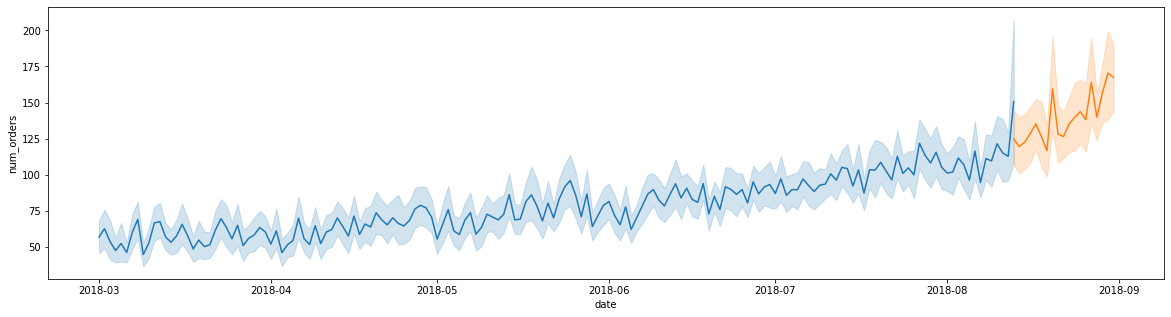

In [24]:
#cek plot ukuran data training dan testing 
plt.figure(figsize=(20,5));
sns.lineplot(data_train['date'],data_train['num_orders']);
sns.lineplot(data_test['date'],data_test['num_orders']);

catatan :
- dari 4416 baris dataset :
  - dibagi menjadi 90% untuk data training sebesar 3974 baris 
  - 10% data untuk testing sebesar 442 baris
- dataset masih memiliki beberapa 'nan' value karena features engineering, selanjutnya 'nan' value ini akan di drop saat keperluan pelatihan dengan metode machine learning

In [25]:
#define fungsi untuk menghitung rmse
def rmse (target, prediction):
    return mean_squared_error (target,prediction)**0.5

### metode tradisional

metode tradisional yang akan digunakan meliputi :
- metode single exponential smooting
- metode Holt winter
- metode ARIMA

In [26]:
#pilih hanya kolom 'date' dan 'num_order' sebagai dataset
df_train = data_train[['date','num_orders']].set_index('date')
df_test = data_test[['date','num_orders']].set_index('date')

In [27]:
#cek train dataset
df_train.head()

,num_orders
date,
2018-03-01,124
2018-03-01,85
2018-03-01,71
2018-03-01,66
2018-03-01,43


In [28]:
#cek test dataset
df_test.head()

,num_orders
date,
2018-08-13,102
2018-08-13,175
2018-08-13,144
2018-08-13,152
2018-08-13,104


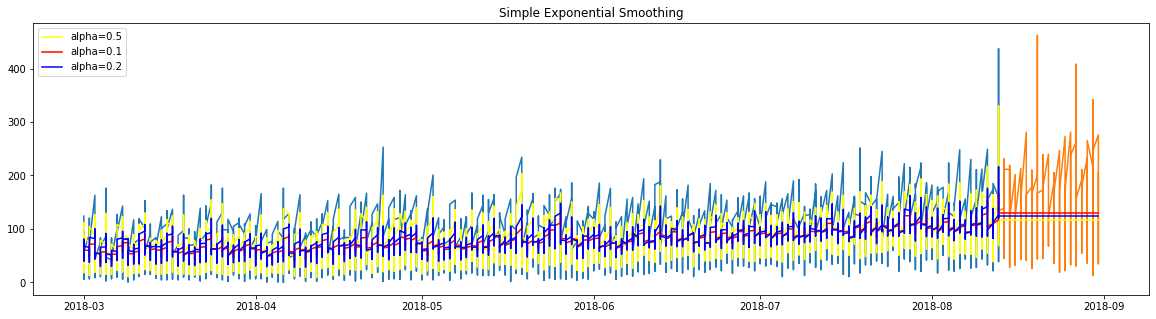

In [29]:
#metode single exponential smooting

model_simple_exp_smoothing = SimpleExpSmoothing(np.asarray(df_train['num_orders']))

fit1 = model_simple_exp_smoothing.fit()
pred1 = fit1.forecast(df_test.shape[0])

fit2 = model_simple_exp_smoothing.fit(smoothing_level=.1)
pred2 = fit2.forecast(df_test.shape[0])

fit3 = model_simple_exp_smoothing.fit(smoothing_level=.2)
pred3 = fit3.forecast(df_test.shape[0])

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_train['num_orders'])
ax.plot(df_test['num_orders'])
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('yellow','red','blue')):
    ax.plot (df_train.index, f.fittedvalues, color=c)
    ax.plot (df_test.index,p,label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title('Simple Exponential Smoothing')
plt.legend();

In [30]:
#cek nilai pred1
pred1

array([116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93683827,
       116.93683827, 116.93683827, 116.93683827, 116.93

In [31]:
#hitung RMSE metode single exponential smooting
rmse(df_test['num_orders'], pred1)

62.76709819684306

catatan :

dengan menggunakan metode single exponential smoothing didapatkan:
- rmse 62.7

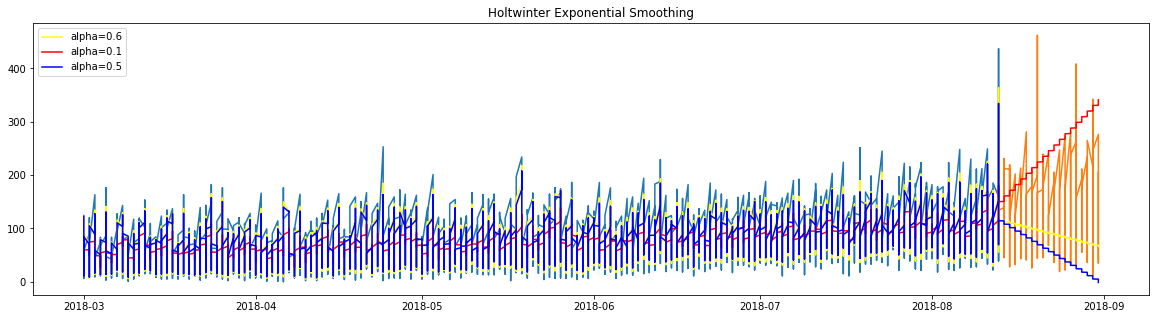

In [32]:
#metode Holt winter
model_Holtwinter_exp_smoothing = Holt(np.asarray(df_train['num_orders']))

fit1 = model_Holtwinter_exp_smoothing.fit()
pred1 = fit1.forecast(df_test.shape[0])

fit2 = model_Holtwinter_exp_smoothing.fit(smoothing_level=.1)
pred2 = fit2.forecast(df_test.shape[0])

fit3 = model_Holtwinter_exp_smoothing.fit(smoothing_level=.5)
pred3 = fit3.forecast(df_test.shape[0])

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_train['num_orders'])
ax.plot(df_test['num_orders'])
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('yellow','red','blue')):
    ax.plot (df_train.index, f.fittedvalues, color=c)
    ax.plot (df_test.index,p,label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title('Holtwinter Exponential Smoothing')
plt.legend();

In [33]:
#cek nilai pred1
pred1

array([115.94454851, 115.83124295, 115.7179374 , 115.60463184,
       115.49132628, 115.37802073, 115.26471517, 115.15140961,
       115.03810406, 114.9247985 , 114.81149294, 114.69818739,
       114.58488183, 114.47157627, 114.35827072, 114.24496516,
       114.1316596 , 114.01835405, 113.90504849, 113.79174293,
       113.67843738, 113.56513182, 113.45182626, 113.33852071,
       113.22521515, 113.11190959, 112.99860404, 112.88529848,
       112.77199292, 112.65868737, 112.54538181, 112.43207625,
       112.3187707 , 112.20546514, 112.09215958, 111.97885403,
       111.86554847, 111.75224291, 111.63893735, 111.5256318 ,
       111.41232624, 111.29902068, 111.18571513, 111.07240957,
       110.95910401, 110.84579846, 110.7324929 , 110.61918734,
       110.50588179, 110.39257623, 110.27927067, 110.16596512,
       110.05265956, 109.939354  , 109.82604845, 109.71274289,
       109.59943733, 109.48613178, 109.37282622, 109.25952066,
       109.14621511, 109.03290955, 108.91960399, 108.80

In [34]:
#hitung RMSE metode HoltWinter exponential smooting
rmse(df_test['num_orders'], pred1)

79.77321663302243

catatan :

dengan menggunakan metode Holtwinter exponential smoothing didapatkan:
- rmse 79.7

In [35]:
# metode ARIMA
y = df_train['num_orders']

ARIMAmodel = ARIMA(y, order = (30,2,5))
ARIMAmodel = ARIMAmodel.fit()


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


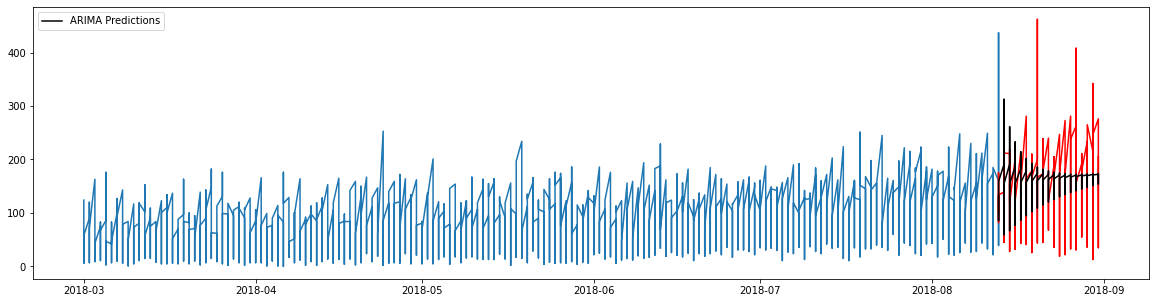

In [36]:
#forecast ARIMA
y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']

plt.figure(figsize=(20,5))
plt.plot(df_train['num_orders'])
plt.plot(df_test['num_orders'], color='red')
plt.plot(y_pred_out, color='black', label ='ARIMA Predictions')
plt.legend()

In [37]:
rmse(df_test['num_orders'], y_pred_out)

53.51269409852247

catatan :

dengan menggunakan metode ARIMA didapatkan:
- rmse 53.5

### Metode Machine Learning

metode machine learning kali ini yang di gunakan adalah :
- Linear regression
- Decission Tree
- Random Forrest
- LGBM

In [38]:
data.head()

,num_orders,date,year,month,day,hour,dayofweek,dayofweek_name,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018-03-01,2018,3,1,0,3,Thursday,1,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018-03-01,2018,3,1,1,3,Thursday,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018-03-01,2018,3,1,2,3,Thursday,1,85.0,124.0,NaN,NaN,93.333333
2018-03-01 03:00:00,66,2018-03-01,2018,3,1,3,3,Thursday,1,71.0,85.0,124.0,93.333333,86.500000
2018-03-01 04:00:00,43,2018-03-01,2018,3,1,4,3,Thursday,1,66.0,71.0,85.0,74.000000,77.800000


In [39]:
#penyusunan features dan target untuk pelatihan model
data_train = data_train.dropna()
features_train = data_train.drop(['num_orders','date','dayofweek_name'], axis=1)
target_train = data_train['num_orders']

features_test = data_test.drop(['num_orders','date','dayofweek_name'], axis=1)
target_test = data_test['num_orders']

In [40]:
#cek features_train data
features_train.head()

,year,month,day,hour,dayofweek,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
datetime,,,,,,,,,,,
2018-03-01 03:00:00,2018,3,1,3,3,1,71.0,85.0,124.0,93.333333,86.500000
2018-03-01 04:00:00,2018,3,1,4,3,1,66.0,71.0,85.0,74.000000,77.800000
2018-03-01 05:00:00,2018,3,1,5,3,1,43.0,66.0,71.0,60.000000,65.833333
2018-03-01 06:00:00,2018,3,1,6,3,1,6.0,43.0,66.0,38.333333,58.142857
2018-03-01 07:00:00,2018,3,1,7,3,1,12.0,6.0,43.0,20.333333,52.750000


In [41]:
#cek features_test data
features_test.head()

,year,month,day,hour,dayofweek,quarter,lag_1,lag_2,lag_3,rolling_mean,expanding_mean
0,2018,8,13,14,0,3,119.0,92.0,144.0,118.333333,78.296604
1,2018,8,13,15,0,3,102.0,119.0,92.0,104.333333,78.320926
2,2018,8,13,16,0,3,175.0,102.0,119.0,132.000000,78.337440
3,2018,8,13,17,0,3,144.0,175.0,102.0,140.333333,78.355958
4,2018,8,13,18,0,3,152.0,144.0,175.0,157.000000,78.362403


In [42]:
#linear Regression
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("MAE untuk training set: ",mean_absolute_error(target_train, pred_train))
print("MAE untuk test set: ",mean_absolute_error(target_test, pred_test))

print('Train RMSE :', rmse(target_train,pred_train).round(5))
print('Test RMSE :', rmse(target_test,pred_test).round(5))

MAE untuk training set:  23.36657091093784
MAE untuk test set:  38.919237873196096
Train RMSE : 30.52021
Test RMSE : 51.21672


catatan :

dengan menggunakan metode Linear Regression didapatkan:
- MAE untuk training set:  23.36657091093784
- MAE untuk test set:  38.919237873196096
- Train RMSE : 30.52021
- Test RMSE : 51.21672

In [43]:
#decission tree
for depth in [1,2,3,4,6,None]:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(features_train,target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print('Depth :', depth)
    print('Train RMSE :', rmse(target_train,pred_train).round(5))
    print('Test RMSE :', rmse(target_test,pred_test).round(5))

Depth : 1
Train RMSE : 34.34402
Test RMSE : 74.07364
Depth : 2
Train RMSE : 31.57586
Test RMSE : 63.09099
Depth : 3
Train RMSE : 28.15967
Test RMSE : 59.45577
Depth : 4
Train RMSE : 26.17832
Test RMSE : 55.72696
Depth : 6
Train RMSE : 22.83328
Test RMSE : 56.39941
Depth : None
Train RMSE : 0.0
Test RMSE : 59.21901


catatan :

dengan menggunakan metode DecissionTree Regression pada depth 6 didapatkan:
- Depth : 6
- Train RMSE :22.83328
- Test RMSE : 55.66404

In [44]:
#RamdomForest
for depth in [1,2,3,4,6,8, None]:
    model = RandomForestRegressor(max_depth=depth, n_estimators = 100)
    model.fit(features_train,target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print('Depth :', depth)
    print('Train RMSE :', rmse(target_train,pred_train).round(5))
    print('Test RMSE :', rmse(target_test,pred_test).round(5))

Depth : 1
Train RMSE : 33.79762
Test RMSE : 74.31658
Depth : 2
Train RMSE : 30.26891
Test RMSE : 66.16858
Depth : 3
Train RMSE : 27.25339
Test RMSE : 60.97331
Depth : 4
Train RMSE : 25.14415
Test RMSE : 53.98013
Depth : 6
Train RMSE : 22.09962
Test RMSE : 49.4516
Depth : 8
Train RMSE : 18.68444
Test RMSE : 48.39517
Depth : None
Train RMSE : 8.38005
Test RMSE : 46.5461


catatan :

dengan menggunakan metode RandomForest Regression pada depth None didapatkan:
- Depth : None
- Train RMSE : 8.33818
- Test RMSE : 46.01577

In [45]:
#LGBM

model = lgb.LGBMRegressor(num_iterations=20, verbose=0, metric='rmse')
model.fit(features_train, target_train, 
          eval_set=(features_test, target_test));

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 81.1354
[2]	valid_0's rmse: 77.9515
[3]	valid_0's rmse: 75.2472
[4]	valid_0's rmse: 72.1727
[5]	valid_0's rmse: 70.1124
[6]	valid_0's rmse: 67.8375
[7]	valid_0's rmse: 65.7386
[8]	valid_0's rmse: 64.0488
[9]	valid_0's rmse: 61.8601
[10]	valid_0's rmse: 60.5962
[11]	valid_0's rmse: 59.3866
[12]	valid_0's rmse: 57.1781
[13]	valid_0's rmse: 56.2466
[14]	valid_0's rmse: 54.5673
[15]	valid_0's rmse: 53.8094
[16]	valid_0's rmse: 53.1662
[17]	valid_0's rmse: 52.2813
[18]	valid_0's rmse: 51.704
[19]	valid_0's rmse: 51.1847
[20]	valid_0's rmse: 50.6222


In [46]:
#pengujian LGBM
pred_train = model.predict (features_train)
pred_test = model.predict (features_test)

print('Train RMSE :', rmse(target_train,pred_train).round(5))
print('Test RMSE :', rmse(target_test,pred_test).round(5))

Train RMSE : 21.43867
Test RMSE : 50.62223


catatan :

dengan menggunakan metode LGBM Regression pada iterasi 20 didapatkan nilai :
- Train RMSE : 21.43867
- Test RMSE : 50.62223

## Kesimpulan

Dari data historis pesanan taksi di perusahaan Sweet Lift, setelah di analisa dengan sampling 1 jam, dan 90% data training dan 10 % data testing didapatkan hasil sebagai berikut :
- RMSE dengan metode analisa tradisional :
  - metode ARIMA didapatkan 53.5
  - metode Holtwinter exponential smoothing 79.7
  - metode single exponential smoothing 62.7
- RMSE dengan metode machine learning :
  - Linear Regression 51.21672
  - Decission Tree 55.66404 pada depth 6
  - RandomForest 46.01577 pada depth none
  - LGBM 60.6

dengan hasil tersebut maka prediksi jumlah pesanan taksi dalam 1 jam kedepan paling baik yaitu dengan menggunakan RandomForest dengan nilai RMSE terkecil yaitu 46.01577